# Experiments with Dropout in Neural Networks

This notebook contains experimental, hacked out code for exploring the concepts in the [dropout paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) for the ATOM reading group in Seattle.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib
matplotlib.style.use('ggplot')

/Users/matthewdrury/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def remove_grid_lines(axs):
    """Remove the default grid lines from a collection of axies."""
    for ax in axs.flatten():
        ax.grid(False)

## The MNIST Dataset

MNIST is a standard toy data set for experimenting with Neural Network models.  It contains grayscale images of handwritten digits, and the tast is to classify the images into digit classes.

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

(55000, 784)
(55000, 10)


In [5]:
print mnist.train.labels[0]

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


Each MNIST image is **flattened** into a single dimensional array of 784 pixel intensities.  The true images are 28 pixels by 28 pixels.

In [6]:
def plot_mnist_digit(ax, image, label):
    """Plot a greyscale image and label its class."""
    first_digit = image.reshape(28, 28)
    ax.imshow(first_digit, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Class: {}".format(label))

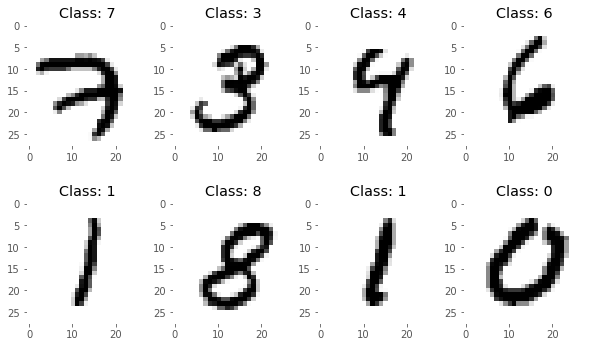

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6))

digit_labels = np.argmax(mnist.train.labels, axis=1)

for i, (image, label, ax) in enumerate(
    zip(mnist.train.images, digit_labels, axs.flatten())):
    plot_mnist_digit(ax, image, label)
    
remove_grid_lines(axs)

## Set up Interactive Session

Getting tensorflow started.

In [8]:
# Set up our tensorflow session.
sess = tf.InteractiveSession()

## Classifying Digits with a Simple Fully Connected Network

As a baseline experiment, we fit a simple fully connected network with *no* hidden later.  This is essentially a multinomial regression, each with one feature per image pixel.

In [9]:
# Placeholder for the input data, grayscale images.
x = tf.placeholder(tf.float32, [None, 28*28])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, 10])
# Weights.  There are 10 output classes, and one weight per (pixel, output class)
# combination.
W = tf.Variable(tf.zeros([28*28, 10]))
# Biasies.  This is like an intercept term in a linear regression.  There is one
# per output class.
b = tf.Variable(tf.zeros([10]))
# Output layer, probabilities of each class.
y_hat = tf.nn.softmax(tf.matmul(x, W) + b)
# Our loss function.
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))

class_prediction = tf.argmax(y_hat, 1)
correct_prediction = tf.equal(class_prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
# Set up our tensorflow session.
sess = tf.InteractiveSession()

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

tf.global_variables_initializer().run()
for _ in range(20000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})

In [11]:
print("Test Error Accuracy: {:0.2f}".format(
        sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})))

Test Error Accuracy: 0.92


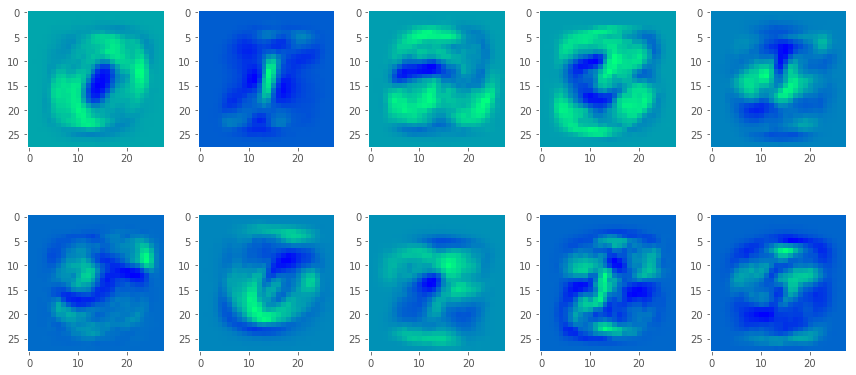

In [12]:
def plot_digit_weights(ax, digit):
    """Plot the weights from our fit fully connected network as an image."""
    digit_weigths = W.eval()[:, digit].reshape(28, -1)
    ax.imshow(digit_weigths, cmap=plt.cm.winter, interpolation="nearest")

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for digit, ax in enumerate(axs.flatten()):
    plot_digit_weights(ax, digit)

remove_grid_lines(axs)
plt.tight_layout()

## Training a Network with One Hidden Layer, No L2 Regularization

In [13]:
# Placeholder for the input data, grayscale images.
x = tf.placeholder(tf.float32, [None, 28*28])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, 10])

n_hidden_units = 64
n_output_classes = 10

# Hidden Layer.
weights_hidden_layer = tf.Variable(tf.truncated_normal(
        shape=[28*28, n_hidden_units], stddev=0.1))
bias_hidden_layer = tf.Variable(tf.constant(0.1, shape=[n_hidden_units]))
linear_hidden_layer = tf.matmul(x, weights_hidden_layer) + bias_hidden_layer
output_hidden_layer = tf.nn.relu(linear_hidden_layer)

# Output Layer.
weights_output_layer = tf.Variable(
    tf.truncated_normal(shape=[n_hidden_units, n_output_classes], stddev=0.1))
bias_output_layer = tf.Variable(tf.constant(0.1, shape=[n_output_classes]))
y_hat = tf.nn.softmax(tf.matmul(output_hidden_layer, weights_output_layer) + bias_output_layer)

prediction = tf.argmax(y_hat, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
# Train the model by gradient descent, for a fixed 1000 iterations.
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy)

n_epoch = 10000
n_iter_output = 200

epochs = []
train_accuracies = []
test_accuracies = []

tf.global_variables_initializer().run()
for i in range(n_epoch):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    if i % n_iter_output == 0:
        epochs.append(i)
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y: batch_ys})
        train_accuracies.append(train_accuracy)
        #print("Train Error Accuracy: {:0.2f}".format(train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels})
        test_accuracies.append(test_accuracy)

In [15]:
print("Test Error Accuracy: {:0.3f}".format(
        sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})))

Test Error Accuracy: 0.97


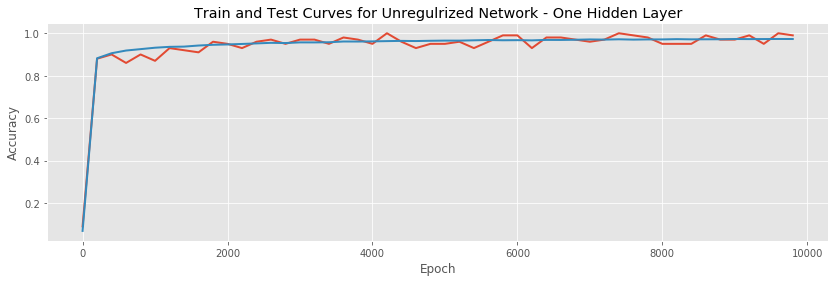

In [16]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(epochs, train_accuracies, label="Train")
ax.plot(epochs, test_accuracies, label="Test")
ax.set_title("Train and Test Curves for Unregulrized Network - One Hidden Layer")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

### Plot Weights in the Hidden Layer

In [148]:
def plot_hidden_layer_weights(ax, tensor, layer_idx):
    """Plot the weights from our fit fully connected network as an image."""
    layer_weights = tensor.eval()[:, layer_idx].reshape(28, 28)
    ax.imshow(layer_weights, cmap=plt.cm.winter, interpolation="nearest")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

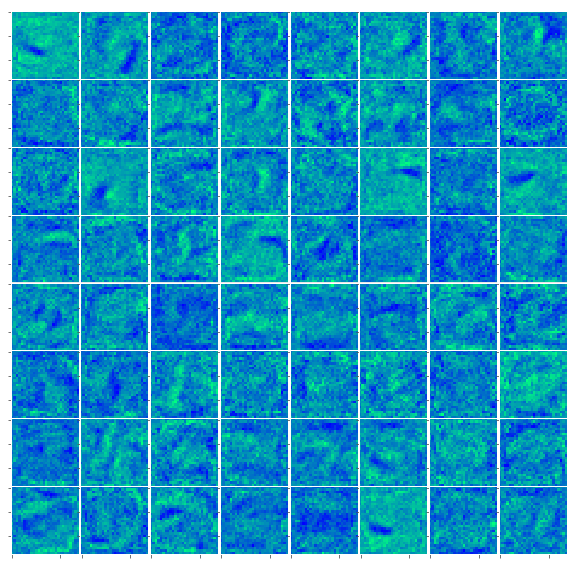

In [18]:
fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for idx, ax in enumerate(axs.flatten()):
    plot_hidden_layer_weights(ax, weights_hidden_layer, idx)
remove_grid_lines(axs)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

### Histogram of Weights in the Hidden Layer

In [19]:
def plot_hidden_layer_weights_hist(ax, weights_tensor):
    hidden_layer_weights = weights_tensor.eval()[:, :].flatten()
    _ = ax.hist(hidden_layer_weights, bins=100, alpha=0.5, color="grey")
    ax.set_title("Weights in Hidden Layer")

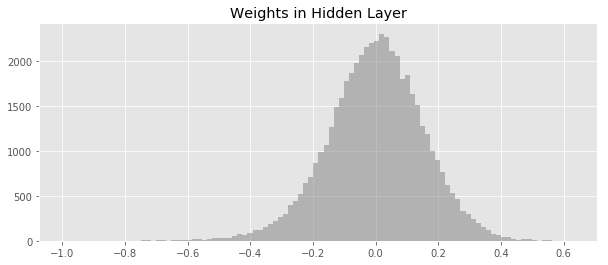

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_weights_hist(ax, weights_hidden_layer)

### Histogram of Activations from Testing Data in Hidden Layer

In [21]:
def plot_hidden_layer_activations(ax, activations_tensor):
    hidden_layer_activations = activations_tensor.eval(
        feed_dict={x: mnist.test.images, y: mnist.test.labels}).flatten()
    _ = ax.hist(hidden_layer_activations, bins=100, alpha=0.5, color="grey")

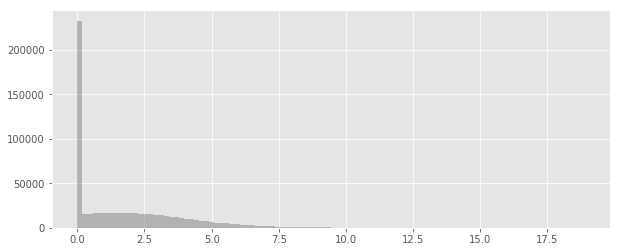

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_activations(ax, output_hidden_layer)

## Training a Network with One Hidden Layer, With L2 Regularization

In [23]:
# Raw loss function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))

# Reguarization
regularization_strength = 0.001
regularization_term = regularization_strength * (
    tf.nn.l2_loss(weights_hidden_layer) +
    tf.nn.l2_loss(weights_output_layer)
)

In [24]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy + regularization_term)

n_epoch = 15000
n_iter_output = 200

epochs = []
train_accuracies = []
test_accuracies = []

tf.global_variables_initializer().run()
for i in range(n_epoch):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    if i % n_iter_output == 0:
        epochs.append(i)
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y: batch_ys})
        train_accuracies.append(train_accuracy)
        #print("Train Error Accuracy: {:0.2f}".format(train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels})
        test_accuracies.append(test_accuracy)

In [25]:
print("Test Error Accuracy: {:0.3f}".format(
        sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})))

Test Error Accuracy: 0.97


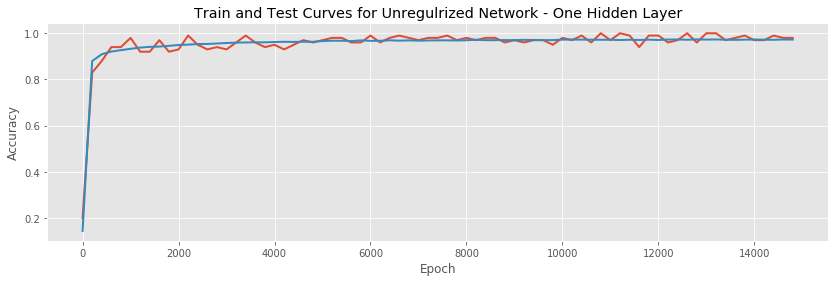

In [26]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(epochs, train_accuracies, label="Train")
ax.plot(epochs, test_accuracies, label="Test")
ax.set_title("Train and Test Curves for Unregulrized Network - One Hidden Layer")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

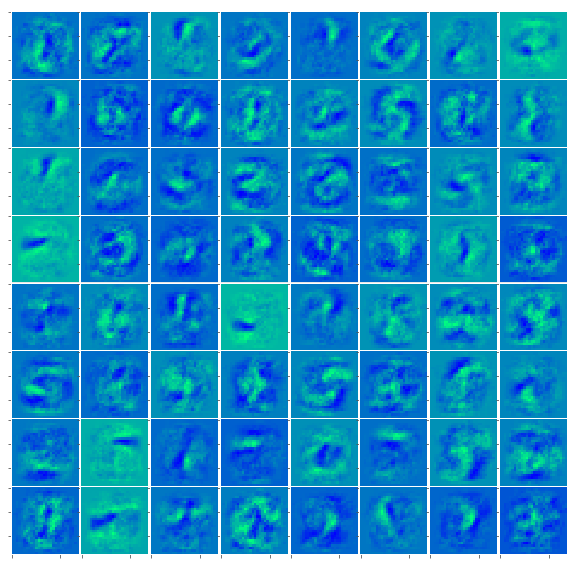

In [27]:
fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for idx, ax in enumerate(axs.flatten()):
    plot_hidden_layer_weights(ax, weights_hidden_layer, idx)
remove_grid_lines(axs)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

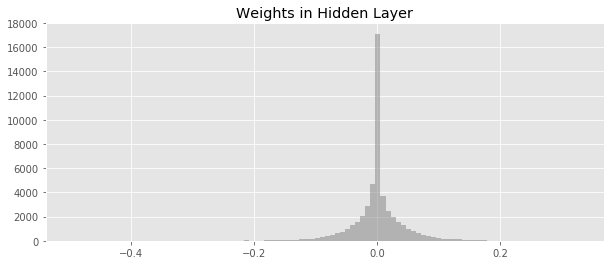

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_weights_hist(ax, weights_hidden_layer)

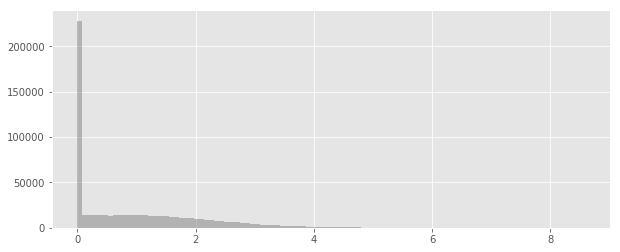

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_activations(ax, output_hidden_layer)

## Training a Network with One Hidden Layer, With Dropout, No Regularization

In [30]:
# Placeholder for the input data, grayscale images.
x = tf.placeholder(tf.float32, [None, 28*28])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, 10])

n_hidden_units = 64
n_output_classes = 10

# Hidden Layer.
weights_hidden_layer = tf.Variable(tf.truncated_normal(
        shape=[28*28, n_hidden_units], stddev=0.1))
bias_hidden_layer = tf.Variable(tf.constant(0.1, shape=[n_hidden_units]))

keep_prob = tf.placeholder(tf.float32)
weights_hidden_layer_with_dropout = tf.nn.dropout(weights_hidden_layer, keep_prob)

linear_hidden_layer = tf.matmul(x, weights_hidden_layer_with_dropout) + bias_hidden_layer
output_hidden_layer = tf.nn.relu(linear_hidden_layer)

# Output Layer.
weights_output_layer = tf.Variable(
    tf.truncated_normal(shape=[n_hidden_units, n_output_classes], stddev=0.1))
bias_output_layer = tf.Variable(tf.constant(0.1, shape=[n_output_classes]))
y_hat = tf.nn.softmax(tf.matmul(output_hidden_layer, weights_output_layer) + bias_output_layer)

prediction = tf.argmax(y_hat, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [31]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy)

n_epoch = 15000
n_iter_output = 500

epochs = []
train_accuracies = []
test_accuracies = []

tf.global_variables_initializer().run()
for i in range(n_epoch):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 0.5})
    if i % n_iter_output == 0:
        epochs.append(i)
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.0})
        train_accuracies.append(train_accuracy)
        #print("Train Error Accuracy: {:0.2f}".format(train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})
        test_accuracies.append(test_accuracy)

In [32]:
print("Test Error Accuracy: {:0.3f}".format(
        sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})))

Test Error Accuracy: 0.97


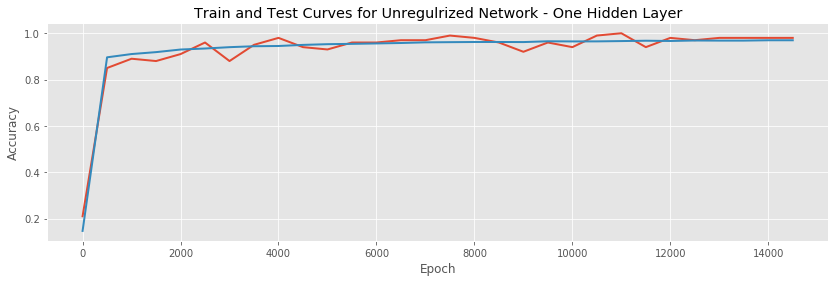

In [33]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(epochs, train_accuracies, label="Train")
ax.plot(epochs, test_accuracies, label="Test")
ax.set_title("Train and Test Curves for Unregulrized Network - One Hidden Layer")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

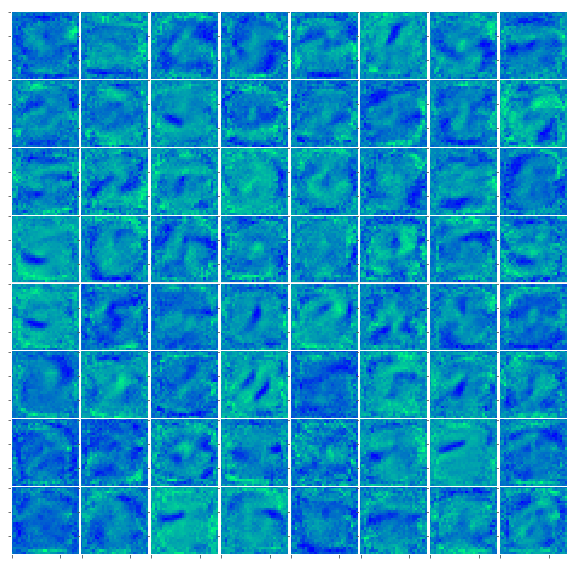

In [34]:
fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for idx, ax in enumerate(axs.flatten()):
    plot_hidden_layer_weights(ax, weights_hidden_layer, idx)
remove_grid_lines(axs)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

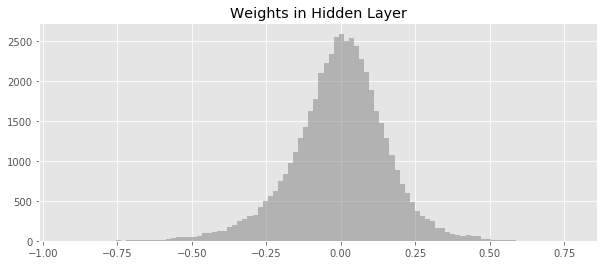

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_weights_hist(ax, weights_hidden_layer)

In [36]:
def plot_hidden_layer_activations(ax, activations_tensor):
    hidden_layer_activations = activations_tensor.eval(
        feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}).flatten()
    _ = ax.hist(hidden_layer_activations, bins=100, alpha=0.5, color="grey")

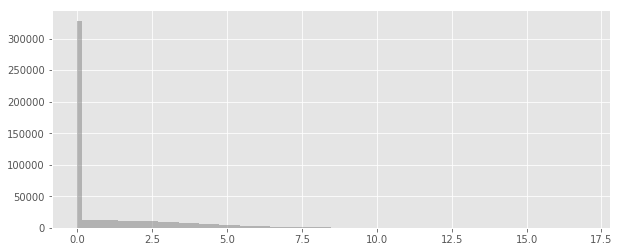

In [37]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_activations(ax, output_hidden_layer)

## Training a Network with One Hidden Layer, With Dropout, With Regularization

In [67]:
# Placeholder for the input data, grayscale images.
x = tf.placeholder(tf.float32, [None, 28*28])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, 10])

n_hidden_units = 64
n_output_classes = 10

# Hidden Layer.
weights_hidden_layer = tf.Variable(tf.truncated_normal(
        shape=[28*28, n_hidden_units], stddev=0.1))
bias_hidden_layer = tf.Variable(tf.constant(0.1, shape=[n_hidden_units]))

keep_prob = tf.placeholder(tf.float32)
weights_hidden_layer_with_dropout = tf.nn.dropout(weights_hidden_layer, keep_prob)

linear_hidden_layer = tf.matmul(x, weights_hidden_layer_with_dropout) + bias_hidden_layer
output_hidden_layer = tf.nn.relu(linear_hidden_layer)

# Output Layer.
weights_output_layer = tf.Variable(
    tf.truncated_normal(shape=[n_hidden_units, n_output_classes], stddev=0.1))
bias_output_layer = tf.Variable(tf.constant(0.1, shape=[n_output_classes]))
y_hat = tf.nn.softmax(tf.matmul(output_hidden_layer, weights_output_layer) + bias_output_layer)

prediction = tf.argmax(y_hat, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [68]:
# Raw loss function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))

# Reguarization
regularization_strength = 0.01
regularization_term = regularization_strength * (
    tf.nn.l2_loss(weights_hidden_layer) +
    tf.nn.l2_loss(weights_output_layer)
)

train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy + regularization_term)

n_epoch = 15000
n_iter_output = 500

epochs = []
train_accuracies = []
test_accuracies = []

tf.global_variables_initializer().run()
for i in range(n_epoch):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 0.5})
    if i % n_iter_output == 0:
        epochs.append(i)
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.0})
        train_accuracies.append(train_accuracy)
        #print("Train Error Accuracy: {:0.2f}".format(train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})
        test_accuracies.append(test_accuracy)

In [69]:
print("Test Error Accuracy: {:0.3f}".format(
        sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})))

Test Error Accuracy: 0.932


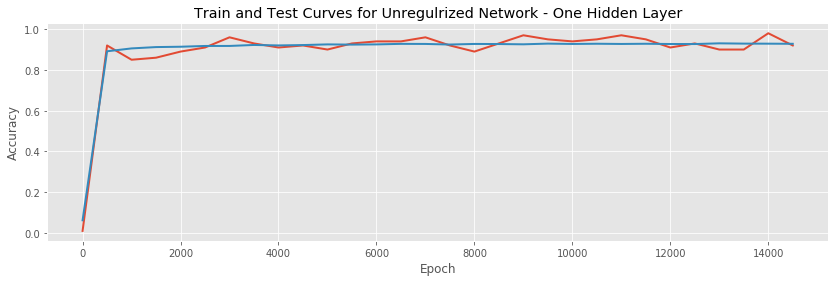

In [70]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(epochs, train_accuracies, label="Train")
ax.plot(epochs, test_accuracies, label="Test")
ax.set_title("Train and Test Curves for Unregulrized Network - One Hidden Layer")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

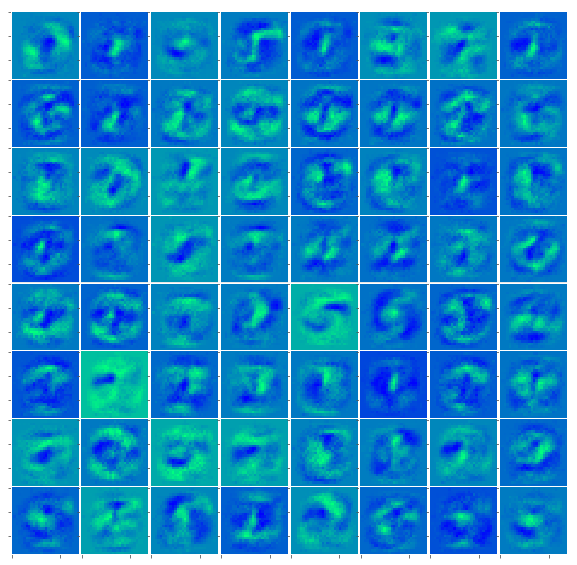

In [71]:
fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for idx, ax in enumerate(axs.flatten()):
    plot_hidden_layer_weights(ax, weights_hidden_layer, idx)

remove_grid_lines(axs)
#plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.0)

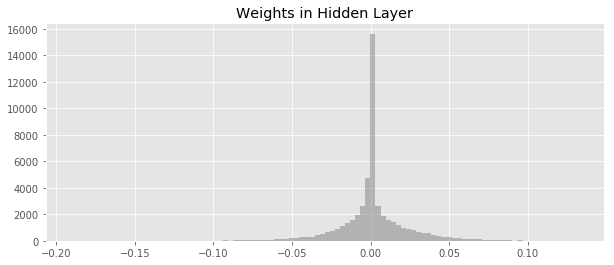

In [72]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_weights_hist(ax, weights_hidden_layer)

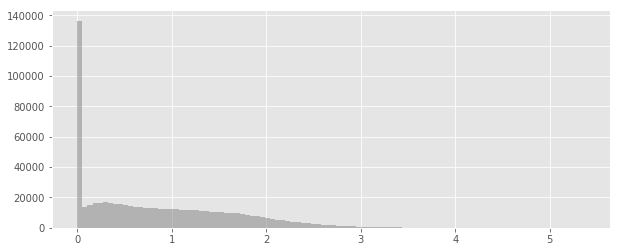

In [73]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_activations(ax, output_hidden_layer)

## Two Hidden Layers

In [74]:
# Placeholder for the input data, grayscale images.
x = tf.placeholder(tf.float32, [None, 28*28])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, 10])

n_hidden_units_layer_1 = 36
n_hidden_units_layer_2 = 25
n_output_classes = 10

# First Hidden Layer
weights_hidden_layer_1 = tf.Variable(tf.truncated_normal(
        shape=[28*28, n_hidden_units_layer_1], stddev=0.1))
bias_hidden_layer_1 = tf.Variable(tf.constant(0.1, shape=[n_hidden_units_layer_1]))
linear_hidden_layer_1 = tf.matmul(x, weights_hidden_layer_1) + bias_hidden_layer_1
output_hidden_layer_1 = tf.nn.relu(linear_hidden_layer_1)

# Second Hidden Layer
weights_hidden_layer_2 = tf.Variable(tf.truncated_normal(
    shape=[n_hidden_units_layer_1, n_hidden_units_layer_2], stddev=0.1))
bias_hidden_layer_2 = tf.Variable(tf.constant(0.1, shape=[n_hidden_units_layer_2]))
linear_hidden_layer_2 = (
    tf.matmul(output_hidden_layer_1, weights_hidden_layer_2) + bias_hidden_layer_2)
output_hidden_layer_2 = tf.nn.relu(linear_hidden_layer_2)

# Output Layer.
weights_output_layer = tf.Variable(
    tf.truncated_normal(shape=[n_hidden_units_layer_2, n_output_classes], stddev=0.1))
bias_output_layer = tf.Variable(tf.constant(0.1, shape=[n_output_classes]))
y_hat = tf.nn.softmax(
    tf.matmul(output_hidden_layer_2, weights_output_layer) + bias_output_layer)

prediction = tf.argmax(y_hat, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [75]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy)

n_epoch = 15000
n_iter_output = 500

epochs = []
train_accuracies = []
test_accuracies = []

tf.global_variables_initializer().run()
for i in range(n_epoch):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    if i % n_iter_output == 0:
        epochs.append(i)
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y: batch_ys})
        train_accuracies.append(train_accuracy)
        #print("Train Error Accuracy: {:0.2f}".format(train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels})
        test_accuracies.append(test_accuracy)

In [76]:
print("Test Error Accuracy: {:0.3f}".format(
        sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})))

Test Error Accuracy: 0.965


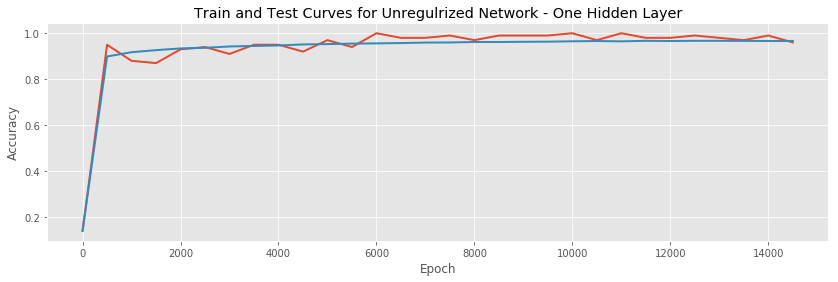

In [77]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(epochs, train_accuracies, label="Train")
ax.plot(epochs, test_accuracies, label="Test")
ax.set_title("Train and Test Curves for Unregulrized Network - One Hidden Layer")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

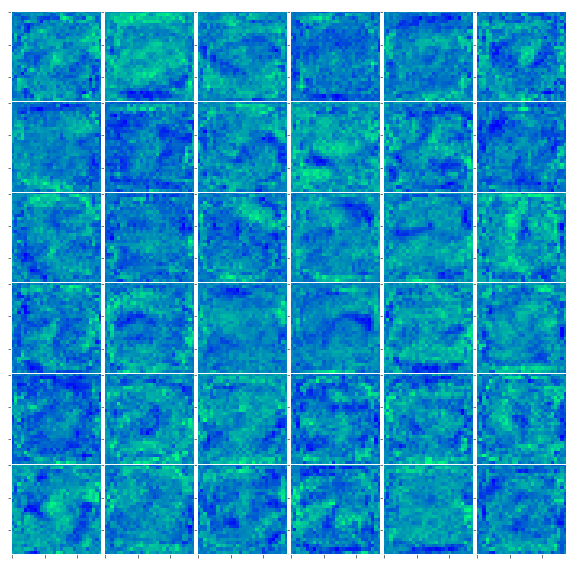

In [79]:
fig, axs = plt.subplots(6, 6, figsize=(10, 10))

for idx, ax in enumerate(axs.flatten()):
    plot_hidden_layer_weights(ax, weights_hidden_layer_1, idx)
remove_grid_lines(axs)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_hidden_layer_weights_hist(ax, weights_hidden_layer_1)

## Two Hidden Layers, With L2 Regularization

In [85]:
# Placeholder for the input data, grayscale images.
x = tf.placeholder(tf.float32, [None, 28*28])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, 10])

n_hidden_units_layer_1 = 36
n_hidden_units_layer_2 = 25
n_output_classes = 10

# First Hidden Layer
weights_hidden_layer_1 = tf.Variable(tf.truncated_normal(
        shape=[28*28, n_hidden_units_layer_1], stddev=0.1))
bias_hidden_layer_1 = tf.Variable(tf.constant(0.1, shape=[n_hidden_units_layer_1]))
linear_hidden_layer_1 = tf.matmul(x, weights_hidden_layer_1) + bias_hidden_layer_1
output_hidden_layer_1 = tf.nn.relu(linear_hidden_layer_1)

# Second Hidden Layer
weights_hidden_layer_2 = tf.Variable(tf.truncated_normal(
    shape=[n_hidden_units_layer_1, n_hidden_units_layer_2], stddev=0.1))
bias_hidden_layer_2 = tf.Variable(tf.constant(0.1, shape=[n_hidden_units_layer_2]))
linear_hidden_layer_2 = (
    tf.matmul(output_hidden_layer_1, weights_hidden_layer_2) + bias_hidden_layer_2)
output_hidden_layer_2 = tf.nn.relu(linear_hidden_layer_2)

# Output Layer.
weights_output_layer = tf.Variable(
    tf.truncated_normal(shape=[n_hidden_units_layer_2, n_output_classes], stddev=0.1))
bias_output_layer = tf.Variable(tf.constant(0.1, shape=[n_output_classes]))
y_hat = tf.nn.softmax(
    tf.matmul(output_hidden_layer_2, weights_output_layer) + bias_output_layer)

prediction = tf.argmax(y_hat, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [86]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))

# Reguarization
regularization_strength = 0.0005
regularization_term = regularization_strength * (
    tf.nn.l2_loss(weights_hidden_layer_1) +
    tf.nn.l2_loss(weights_hidden_layer_2) +
    tf.nn.l2_loss(weights_output_layer)
)

train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy + regularization_term)

n_epoch = 25000
n_iter_output = 500

epochs = []
train_accuracies = []
test_accuracies = []

tf.global_variables_initializer().run()
for i in range(n_epoch):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys})
    if i % n_iter_output == 0:
        epochs.append(i)
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y: batch_ys})
        train_accuracies.append(train_accuracy)
        #print("Train Error Accuracy: {:0.2f}".format(train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels})
        test_accuracies.append(test_accuracy)

In [87]:
print("Test Error Accuracy: {:0.3f}".format(
        sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})))

Test Error Accuracy: 0.971


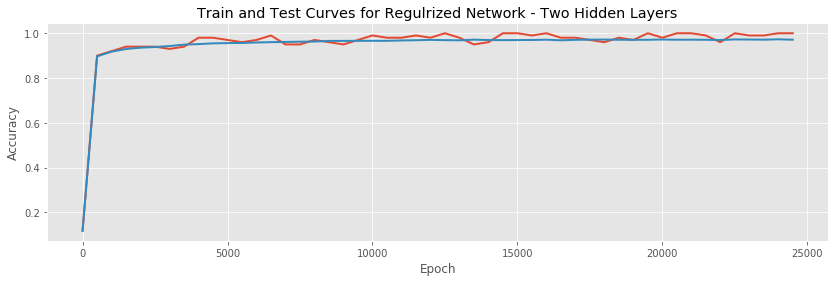

In [88]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(epochs, train_accuracies, label="Train")
ax.plot(epochs, test_accuracies, label="Test")
ax.set_title("Train and Test Curves for Regulrized Network - Two Hidden Layers")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

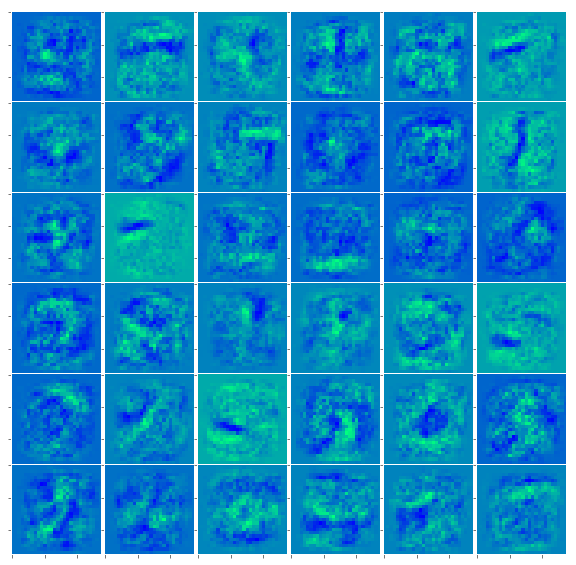

In [89]:
fig, axs = plt.subplots(6, 6, figsize=(10, 10))

for idx, ax in enumerate(axs.flatten()):
    plot_hidden_layer_weights(ax, weights_hidden_layer_1, idx)
remove_grid_lines(axs)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

## Two Hidden Layers, With Dropout, No L2 Regularization

In [187]:
# Placeholder for the input data, grayscale images.
x = tf.placeholder(tf.float32, [None, 28*28])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, 10])

n_hidden_units_layer_1 = 36
n_hidden_units_layer_2 = 16
n_output_classes = 10
keep_prob = 0.5

# First Hidden Layer
weights_hidden_layer_1_no_dropout = tf.Variable(tf.truncated_normal(
        shape=[28*28, n_hidden_units_layer_1], stddev=0.1))
keep_prob = tf.placeholder(tf.float32)
weights_hidden_layer_1 = tf.nn.dropout(
    weights_hidden_layer_1_no_dropout, keep_prob)
bias_hidden_layer_1 = tf.Variable(tf.constant(0.1, shape=[n_hidden_units_layer_1]))
linear_hidden_layer_1 = tf.matmul(x, weights_hidden_layer_1) + bias_hidden_layer_1
output_hidden_layer_1 = tf.nn.relu(linear_hidden_layer_1)

# Second Hidden Layer
weights_hidden_layer_2_no_dropout = tf.Variable(tf.truncated_normal(
    shape=[n_hidden_units_layer_1, n_hidden_units_layer_2], stddev=0.1))
weights_hidden_layer_2 = tf.nn.dropout(
    weights_hidden_layer_2_no_dropout, keep_prob)
bias_hidden_layer_2 = tf.Variable(tf.constant(0.1, shape=[n_hidden_units_layer_2]))
linear_hidden_layer_2 = (
    tf.matmul(output_hidden_layer_1, weights_hidden_layer_2) + bias_hidden_layer_2)
output_hidden_layer_2 = tf.nn.relu(linear_hidden_layer_2)

# Output Layer.
weights_output_layer = tf.Variable(
    tf.truncated_normal(shape=[n_hidden_units_layer_2, n_output_classes], stddev=0.1))
bias_output_layer = tf.Variable(tf.constant(0.1, shape=[n_output_classes]))
y_hat = tf.nn.softmax(
    tf.matmul(output_hidden_layer_2, weights_output_layer) + bias_output_layer)

prediction = tf.argmax(y_hat, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [188]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

n_epoch = 30000
n_iter_output = 500

epochs = []
train_accuracies = []
test_accuracies = []

tf.global_variables_initializer().run()
for i in range(n_epoch):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, 
             feed_dict={x: batch_xs, y: batch_ys, keep_prob: 0.5})
    if i % n_iter_output == 0:
        epochs.append(i)
        train_accuracy = accuracy.eval(
            feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.0})
        train_accuracies.append(train_accuracy)
        #print("Train Error Accuracy: {:0.2f}".format(train_accuracy))
        test_accuracy = accuracy.eval(
            feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})
        test_accuracies.append(test_accuracy)

In [189]:
print("Test Error Accuracy: {:0.3f}".format(
        sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})))

Test Error Accuracy: 0.929


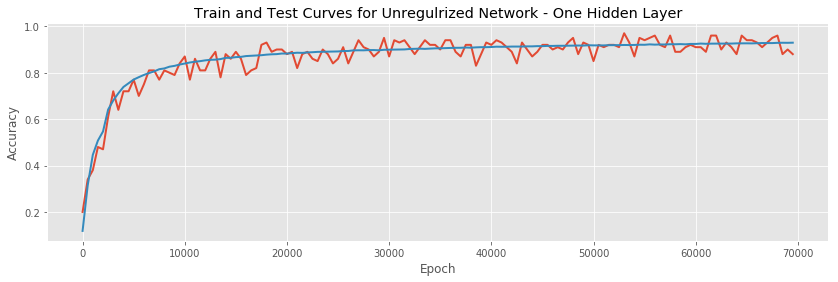

In [190]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(epochs, train_accuracies, label="Train")
ax.plot(epochs, test_accuracies, label="Test")
ax.set_title("Train and Test Curves for Unregulrized Network - One Hidden Layer")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

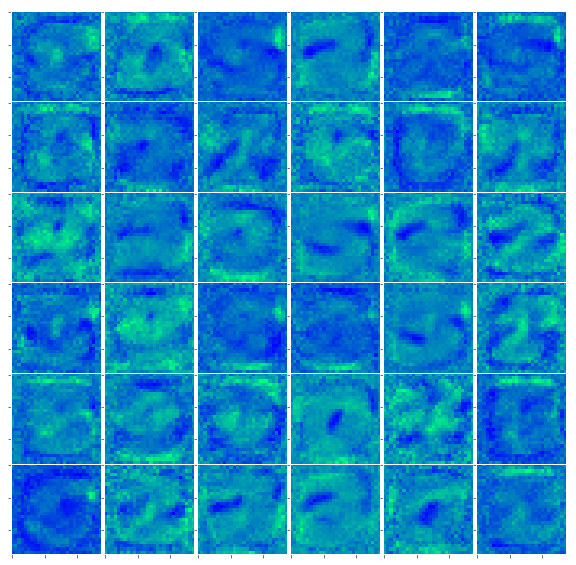

In [191]:
fig, axs = plt.subplots(6, 6, figsize=(10, 10))

for idx, ax in enumerate(axs.flatten()):
    plot_hidden_layer_weights(ax, weights_hidden_layer_1_no_dropout, idx)
remove_grid_lines(axs)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

In [192]:
def plot_deep_hidden_layer_weights(ax, tensor, shape):
    layer_weights = tensor.eval().reshape(shape)
    ax.imshow(layer_weights, cmap=plt.cm.winter, interpolation="nearest")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

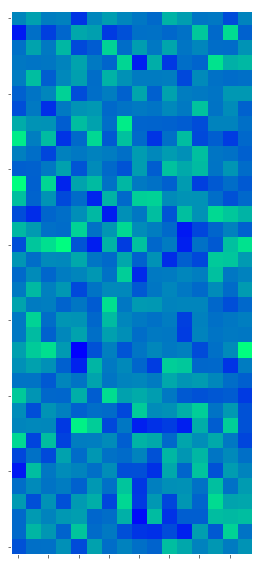

In [193]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_deep_hidden_layer_weights(
    ax, weights_hidden_layer_2_no_dropout, (36, 16))
ax.grid(False)

## Two Hidden Layers, With Dropout, and L2 Regularization

In [ ]:
# Placeholder for the input data, grayscale images.
x = tf.placeholder(tf.float32, [None, 28*28])
# Placeholder for input class labels.
y = tf.placeholder(tf.float32, [None, 10])

n_hidden_units_layer_1 = 36
n_hidden_units_layer_2 = 25
n_output_classes = 10
keep_prob = 0.5

# First Hidden Layer
weights_hidden_layer_1_no_dropout = tf.Variable(tf.truncated_normal(
        shape=[28*28, n_hidden_units_layer_1], stddev=0.1))
keep_prob = tf.placeholder(tf.float32)
weights_hidden_layer_1 = tf.nn.dropout(
    weights_hidden_layer_1_no_dropout, keep_prob)
bias_hidden_layer_1 = tf.Variable(tf.constant(0.1, shape=[n_hidden_units_layer_1]))
linear_hidden_layer_1 = tf.matmul(x, weights_hidden_layer_1) + bias_hidden_layer_1
output_hidden_layer_1 = tf.nn.relu(linear_hidden_layer_1)

# Second Hidden Layer
weights_hidden_layer_2_no_dropout = tf.Variable(tf.truncated_normal(
    shape=[n_hidden_units_layer_1, n_hidden_units_layer_2], stddev=0.1))
weights_hidden_layer_2 = tf.nn.dropout(
    weights_hidden_layer_2_no_dropout, keep_prob)
bias_hidden_layer_2 = tf.Variable(tf.constant(0.1, shape=[n_hidden_units_layer_2]))
linear_hidden_layer_2 = (
    tf.matmul(output_hidden_layer_1, weights_hidden_layer_2) + bias_hidden_layer_2)
output_hidden_layer_2 = tf.nn.relu(linear_hidden_layer_2)

# Output Layer.
weights_output_layer = tf.Variable(
    tf.truncated_normal(shape=[n_hidden_units_layer_2, n_output_classes], stddev=0.1))
bias_output_layer = tf.Variable(tf.constant(0.1, shape=[n_output_classes]))
y_hat = tf.nn.softmax(
    tf.matmul(output_hidden_layer_2, weights_output_layer) + bias_output_layer)

prediction = tf.argmax(y_hat, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1]))

# Reguarization
regularization_strength = 0.0005
regularization_term = regularization_strength * (
    tf.nn.l2_loss(weights_hidden_layer_1) +
    tf.nn.l2_loss(weights_hidden_layer_2) +
    tf.nn.l2_loss(weights_output_layer)
)

train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy + regularization_term)

n_epoch = 40000
n_iter_output = 500

epochs = []
train_accuracies = []
test_accuracies = []

tf.global_variables_initializer().run()
for i in range(n_epoch):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, 
             feed_dict={x: batch_xs, y: batch_ys, keep_prob: 0.5})
    if i % n_iter_output == 0:
        epochs.append(i)
        train_accuracy = accuracy.eval(
            feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.0})
        train_accuracies.append(train_accuracy)
        #print("Train Error Accuracy: {:0.2f}".format(train_accuracy))
        test_accuracy = accuracy.eval(
            feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})
        test_accuracies.append(test_accuracy)